In [1]:
import numpy as np
import argparse
import imageio
import os
import sys
import time
import torch
from datasets import load_dataset
from halluc_vae import HallucVAE
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from torch.utils.data.distributed import DistributedSampler
from torchvision.transforms import ToTensor
from pretrain.data import set_up_data, set_up_imagenet64
from pretrain.utils import get_cpu_stats_over_ranks
from pretrain.train_helpers import set_up_hyperparams, load_vaes, load_opt, accumulate_stats, save_model, update_ema, Hyperparams, add_vae_arguments, parse_args_and_update_hparams, setup_mpi, setup_save_dirs, logger

/home/mila/c/colin.bredenberg/scratch/vdvae/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#function for loading the hyperparameters used to train the original VDVAE model
def set_up_notebook_hps(s = None):
    H = Hyperparams()
    parser = argparse.ArgumentParser()
    parser = add_vae_arguments(parser)
    parse_args_and_update_hparams(H, parser, s=s)
    setup_mpi(H)
    setup_save_dirs(H)
    logprint = logger(H.logdir)
    for i, k in enumerate(sorted(H)):
        logprint(type='hparam', key=k, value=H[k])
    np.random.seed(H.seed)
    torch.manual_seed(H.seed)
    # torch.cuda.manual_seed(H.seed)
    logprint('training model', H.desc, 'on', H.dataset)
    return H, logprint

dataset = "imagenet64" # dataset used to train the VDVAE. Options are "imagenet64" and "ffhq256"

if dataset == "ffhq256":
    original_argv = sys.argv
    sys.argv = ['halluc.ipynb', '--hps', 'ffhq256', '--restore_path', 'ffhq256-iter-1700000-model.th', '--restore_ema_path', 'ffhq256-iter-1700000-model-ema.th', '--restore_log_path', 'ffhq256-iter-1700000-log.jsonl', '--restore_optimizer_path', 'ffhq256-iter-1700000-opt.th', '--test_eval']

    H, logprint = set_up_notebook_hps()
    H, data_train, data_valid_or_test, preprocess_fn = set_up_data(H)
    del data_train

elif dataset == "imagenet64":
    original_argv = sys.argv
    sys.argv = ['halluc.ipynb', '--hps', 'imagenet64', '--restore_path', 'imagenet64-iter-1600000-model.th', '--restore_ema_path', 'imagenet64-iter-1600000-model-ema.th', '--restore_log_path', 'imagenet64-iter-1600000-log.jsonl', '--restore_optimizer_path', 'imagenet64-iter-1600000-opt.th', '--test_eval']

    ds = load_dataset("zh-plus/tiny-imagenet")
    offset = 3
    a = ds['valid']['image'][offset:(1000 + offset):100]
    fig, ax = plt.subplots(1,10, figsize = (10*3, 3))
    for ii in range(0,10):
        ax[ii].imshow(a[ii])
        ax[ii].set_xticks([])
        ax[ii].set_yticks([])
    to_tensor_transform = ToTensor()
    valid_list = []
    for im in ds['valid']['image']:
        im_tensor = to_tensor_transform(im)
        if im_tensor.shape[0] == 3:
            valid_list.append(im_tensor)
    validation_set = torch.stack(valid_list).permute([0,2,3,1])

    H, logprint = set_up_notebook_hps()
    H, data_valid_or_test, preprocess_fn = set_up_imagenet64(H, validation_set)


time: Mon Oct  6 17:12:02 2025, type: hparam, key: adam_beta1, value: 0.90000
time: Mon Oct  6 17:12:02 2025, type: hparam, key: adam_beta2, value: 0.90000
time: Mon Oct  6 17:12:02 2025, type: hparam, key: bottleneck_multiple, value: 0.25000
time: Mon Oct  6 17:12:02 2025, type: hparam, key: custom_width_str, value: 
time: Mon Oct  6 17:12:02 2025, type: hparam, key: data_root, value: ./
time: Mon Oct  6 17:12:02 2025, type: hparam, key: dataset, value: ffhq_256
time: Mon Oct  6 17:12:02 2025, type: hparam, key: dec_blocks, value: 1x2,4m1,4x3,8m4,8x4,16m8,16x9,32m16,32x21,64m32,64x13,128m64,128x7,256m128
time: Mon Oct  6 17:12:02 2025, type: hparam, key: desc, value: test
time: Mon Oct  6 17:12:02 2025, type: hparam, key: ema_rate, value: 0.99900
time: Mon Oct  6 17:12:02 2025, type: hparam, key: enc_blocks, value: 256x3,256d2,128x8,128d2,64x12,64d2,32x17,32d2,16x7,16d2,8x5,8d2,4x5,4d4,1x4
time: Mon Oct  6 17:12:02 2025, type: hparam, key: epochs_per_eval, value: 1
time: Mon Oct  6 17

In [3]:
#Save a few sample input datapoints (and blank images) to avoid loading full datasets
valid_sampler = RandomSampler(data_valid_or_test)
data_loader =  DataLoader(data_valid_or_test, batch_size=1, drop_last=True, pin_memory=True, sampler=valid_sampler)
batch_size = 10
data_inputs = []
data_zeros = []
targets = []
data_loader_iter = iter(data_loader)
for ii in range(0, batch_size):
    data = next(data_loader_iter)
    data_input, target = preprocess_fn(data)
    data_zero, _ = preprocess_fn([torch.zeros(data[0].shape)])
    data_inputs.append(data_input)
    data_zeros.append(data_zero)
    targets.append(target)

print(data_input.shape)
torch.save([data_inputs, data_zeros, targets, H] , "example_input.pt")

torch.Size([1, 256, 256, 3])


In [4]:
# H, logprint = set_up_notebook_hps()
#load data and pretrained VDVAE model
example_inputs, zero_inputs, targets, H= torch.load("example_input.pt", weights_only=False)
vae, ema_vae = load_vaes(H, logprint)
input_data = torch.vstack(example_inputs)
zero_data = torch.vstack(zero_inputs)

time: Mon Oct  6 17:13:22 2025, message: Restoring vae from ffhq256-iter-1700000-model.th
time: Mon Oct  6 17:13:24 2025, message: Restoring ema vae from ffhq256-iter-1700000-model-ema.th
time: Mon Oct  6 17:13:26 2025, total_params: 114874852, readable: 114,874,852


In [5]:
halluc_vae = HallucVAE(ema_vae)

#input-conditioned hallucinations
step_num = 6
abstraction_depth = 35 #use encoder for top K layers
alpha_range = np.array([0., 0.6, 0.7, 0.8, 0.9, 1.0])#np.arange(0, 1.2, 0.2)
samples = []
for idx, a in enumerate(alpha_range):
    sample, metrics = halluc_vae.mixed_sample(input_data, alpha = a, depth = abstraction_depth)
    samples.append(sample)

#closed eyes hallucinations
zero_samples = []
for idx, a in enumerate(alpha_range):
    sample, metrics = halluc_vae.mixed_sample(zero_data, alpha = a, depth = abstraction_depth)
    zero_samples.append(sample)

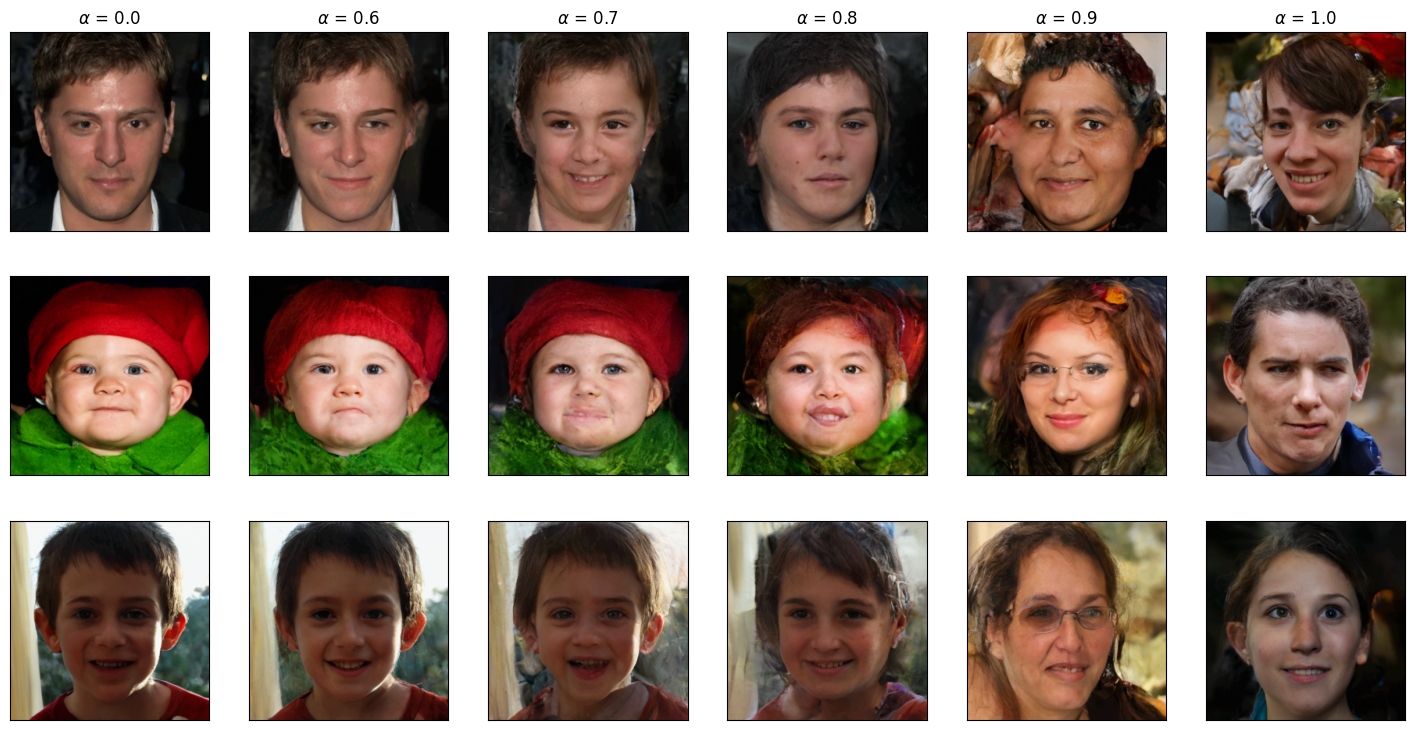

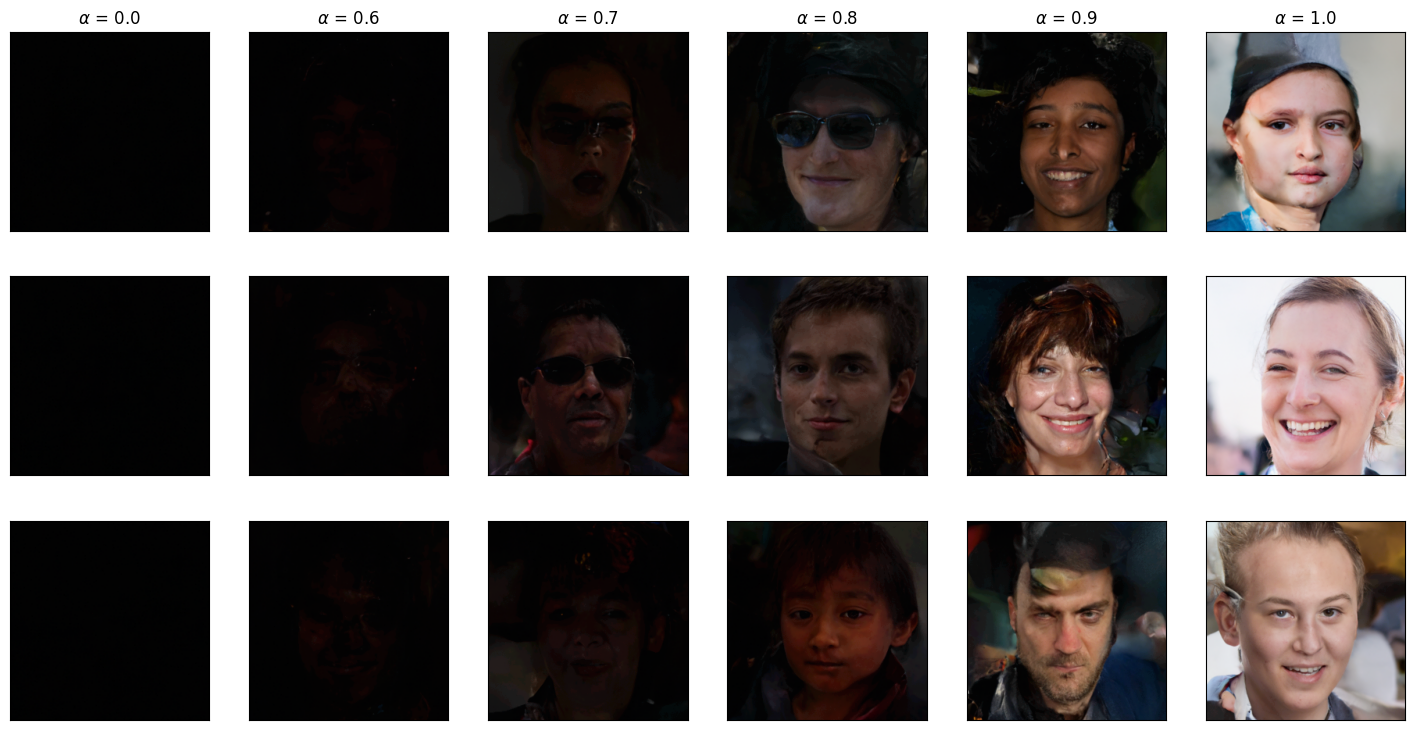

In [6]:
#generate open- and closed-eyes hallucination visualizations
savepath = "./"
sample_num = 3
fig, ax = plt.subplots(sample_num, step_num, figsize = (3 * step_num, 3 * sample_num))
if dataset == 'imagenet64':
    sample_idxs = [2, 8, 9]
elif dataset == 'ffhq256':
    sample_idxs = [2, 5, 7]
for ii in range(0, len(alpha_range)):
    for jj in range(0, sample_num):
        ax[jj,ii].imshow(samples[ii][sample_idxs[jj],...])
        ax[jj,ii].set_xticks([])
        ax[jj,ii].set_yticks([])
    ax[0,ii].set_title(rf"$\alpha$ = {round(alpha_range[ii],2)}", fontsize = 12)
fig.savefig(savepath + f"{dataset}_halluc.pdf", format = 'pdf')
sample_num = 3
fig, ax = plt.subplots(sample_num, step_num, figsize = (3 * step_num, 3 * sample_num))
for ii in range(0, len(alpha_range)):
    for jj in range(0, sample_num):
        ax[jj,ii].imshow(zero_samples[ii][sample_idxs[jj],...])
        ax[jj,ii].set_xticks([])
        ax[jj,ii].set_yticks([])
    ax[0,ii].set_title(rf"$\alpha$ = {round(alpha_range[ii],2)}", fontsize = 12)
fig.savefig(savepath + f"{dataset}_halluc_closed_eyes.pdf", format = 'pdf')


In [ ]:
# stimulus conditioned representation variance
# NOTE: runtime is ~30 minutes for this code cell
from tqdm import tqdm
valid_sampler = RandomSampler(data_valid_or_test)
batch_size = 1
data_loader =  DataLoader(data_valid_or_test, batch_size=1, drop_last=True, pin_memory=True, sampler=valid_sampler)

halluc_vae = HallucVAE(ema_vae)

sample_num = 100
repetition_num = 32
abstraction_depth = 35 #use encoder for top K layers
alpha_range = np.arange(0, 1.1, 0.1)
metrics = {a: [] for a in alpha_range}

data_iterable = iter(data_loader)
for ii in tqdm(range(0, sample_num)):
    for idx, a in enumerate(alpha_range):
        input_data = next(data_iterable)
        data, _ = preprocess_fn(input_data)
        data = data.repeat(repetition_num, 1, 1, 1)
        sample, metric = halluc_vae.mixed_sample(data, alpha = a, depth = abstraction_depth, metrics = ['variance'])
        metrics[a].append(metric)


In [ ]:
#Generate plots for stimulus-conditioned variance
savepath = "./"
res = 16 #corresponds to layer 30
corresponding_layer = 30
layer_vars = {a: [metrics[a][ii]['variance'][res] for ii in range(0, len(metrics[a]))] for a in metrics.keys()}
layer_vars_mean = {a: torch.mean(torch.stack(layer_vars[a])) for a in layer_vars.keys()}
layer_vars_sem = {a: torch.std(torch.stack(layer_vars[a]))/np.sqrt(len(torch.stack(layer_vars[a]))) for a in layer_vars.keys()}
layer_vars_mean = torch.tensor(list(layer_vars_mean.values()))
layer_vars_sem = torch.tensor(list(layer_vars_sem.values()))

fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.errorbar(alpha_range, layer_vars_mean, yerr = layer_vars_sem)
plt.title(f'{dataset} layer {corresponding_layer}')
plt.xlabel('alpha')
plt.ylabel('stimulus conditioned variance')
fig.savefig(savepath + f"{dataset}_stim_cond_var.pdf", format = 'pdf')

In [ ]:
# effects of top-down inactivation
from tqdm import tqdm
valid_sampler = RandomSampler(data_valid_or_test)
batch_size = 100
data_loader =  DataLoader(data_valid_or_test, batch_size=batch_size, drop_last=True, pin_memory=True, sampler=valid_sampler)

halluc_vae = HallucVAE(ema_vae)

abstraction_depth = 35 #use encoder for top K layers
alpha_range = np.arange(0, 1.1, 0.1)
metrics = {a: [] for a in alpha_range}
metrics_inact = {a: [] for a in alpha_range}
samples = {a: [] for a in alpha_range}

sample_num = 1
data_iterable = iter(data_loader)
layer_inactivation_list = list(range(0,20)) #inactivate top 20 layers
for ii in tqdm(range(0, sample_num)):
    input_data = next(data_iterable)
    for idx, a in enumerate(alpha_range):
        data, _ = preprocess_fn(input_data)
        sample, metric = halluc_vae.mixed_sample(data, alpha = a, depth = abstraction_depth, metrics = ['variance', 'spatial_covariance'])
        metrics[a].append(metric)
        samples[a].append(sample)

        sample_inact, metric_inact = halluc_vae.mixed_sample(data, alpha = a, depth = abstraction_depth, metrics = ['variance'], inact_inputs = layer_inactivation_list)
        metrics_inact[a].append(metric_inact)

In [ ]:
#Generate plots analyzing the effects of top-down inactivation
savepath = "./"
res = 16
corresponding_layer = 30
layer_vars = {a: [metrics[a][ii]['variance'][res] for ii in range(0, len(metrics[a]))] for a in metrics.keys()}
layer_vars_inact = {a: [metrics_inact[a][ii]['variance'][res] for ii in range(0, len(metrics_inact[a]))] for a in metrics_inact.keys()}

eps = 1e-3
var_ratio_mean = {a: torch.mean((torch.stack(layer_vars_inact[a]) + eps) / (torch.stack(layer_vars[a]) + eps)) for a in layer_vars.keys()}
var_ratio_std = {a: torch.std((torch.stack(layer_vars_inact[a]) + eps)/ (torch.stack(layer_vars[a]) + eps)) for a in layer_vars.keys()}
var_ratio_mean = torch.tensor(list(var_ratio_mean.values()))
var_ratio_std = torch.tensor(list(var_ratio_std.values()))
var_ratio_sem = var_ratio_std / np.sqrt(np.prod(torch.stack(layer_vars_inact[0.]).shape))

fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.errorbar(alpha_range, var_ratio_mean, yerr = var_ratio_sem)
plt.plot(alpha_range, torch.ones_like(var_ratio_mean), 'k')
plt.title(f'{dataset} layer {corresponding_layer}')
plt.xlabel('alpha')
plt.ylabel('across-stimulus variance ratio')
fig.savefig(savepath + f"{dataset}_var_ratio_inact.pdf", format = 'pdf')


var_ratio_pop = {a: (torch.mean(torch.stack(layer_vars_inact[a])) + eps) / (torch.mean(torch.stack(layer_vars[a])) + eps) for a in layer_vars.keys()}
var_ratio_pop = torch.tensor(list(var_ratio_pop.values()))
fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.plot(alpha_range, var_ratio_pop)
plt.plot(alpha_range, torch.ones_like(var_ratio_pop), 'k')
# plt.plot(alpha_range, layer_vars_mean_inact)
plt.title(f'{dataset} layer {corresponding_layer} pop var ratio')
plt.xlabel('alpha')
plt.ylabel('across-stimulus variance ratio')
fig.savefig(savepath + f"{dataset}_var_ratio_inact_population.pdf", format = 'pdf')

In [ ]:
#correlation similarity plots
def corr_similarity(mat_1, mat_2):
    return torch.corrcoef(torch.stack([mat_1.flatten(), mat_2.flatten()]))[0,1]

def cosine_similarity(mat_1, mat_2):
    flat_1 =  mat_1.flatten() / torch.linalg.norm(mat_1.flatten(), keepdims = True)
    flat_2 = mat_2.flatten() / torch.linalg.norm(mat_2.flatten(), keepdims = True)
    return torch.matmul(flat_1, flat_2)

savepath = "./"
res = 16
corresponding_layer = 30
layer_covs = {a: [metrics[a][ii]['spatial_covariance'][res] for ii in range(0, len(metrics[a]))] for a in metrics.keys()}
layer_stds = {a: torch.sqrt(torch.diag(torch.diag(layer_covs[a][0]))) for a in layer_covs.keys()}
layer_corrs = {a: torch.linalg.inv(layer_stds[a]) @ layer_covs[a][0] @ torch.linalg.inv(layer_stds[a]) for a in layer_covs.keys()}

correlation_similarities = {a: cosine_similarity(torch.triu(layer_corrs[0.].cpu(), diagonal = 1), torch.triu(layer_corrs[a].cpu(), diagonal = 1)) for a in layer_corrs.keys()}

corr_sims = torch.tensor(list(correlation_similarities.values()))
fig, ax = plt.subplots(1,1,figsize = (3,3))
plt.scatter(alpha_range, corr_sims)
plt.title(f'{dataset} layer {corresponding_layer} corr_sims')
plt.xlabel('alpha')
plt.ylabel('across-stimulus correlation similarity')
plt.ylim([0,1])
fig.savefig(savepath + f"{dataset}_correlation_similarities.pdf", format = 'pdf')



In [ ]:
# multiscale analysis (Laplacian pyramid)
import pyrtools as pt

alpha_range = np.arange(0, 1.1, 0.1)
sample_idx = 3
base_ims = samples[alpha_range[0]][0][sample_idx,...]
base_coeffs = pt.pyramids.LaplacianPyramid(base_ims[...].mean(axis = 2))
halluc_coeffs = []
for ii in range(0, len(samples)):
    halluc_coeffs.append(pt.pyramids.LaplacianPyramid(samples[alpha_range[ii]][0][sample_idx,...].mean(axis = 2)))

plt.figure(figsize = (2,2))
plt.imshow(samples[alpha_range[0]][0][sample_idx,...])
plt.xticks([])
plt.yticks([])

alpha_plot_vals = np.array([0., 0.4, 0.8])
alpha_num = len(alpha_plot_vals)
scale_num = len(base_coeffs.pyr_coeffs.keys())
sample_num = 100

fig, ax = plt.subplots(alpha_num, scale_num + 1, figsize = (1 * (scale_num + 1), 1 * alpha_num))
for ii in range(0, alpha_num):
    ax[ii,0].imshow(samples[alpha_plot_vals[ii]][0][sample_idx,...].mean(axis = 2), cmap = 'gray')
    ax[ii,0].set_xticks([])
    ax[ii,0].set_yticks([])
    ax[ii,0].set_ylabel(rf'$\alpha$ = {round(alpha_plot_vals[ii],2)}')
    for jj in range(1, scale_num + 1):
        if ii == 0:
            ax[ii,jj].set_title(f'lvl = {jj}')
        ax[ii,jj].imshow(halluc_coeffs[ii].pyr_coeffs[(jj - 1, 0)], cmap = 'gray')
        ax[ii,jj].set_xticks([])
        ax[ii,jj].set_yticks([])
fig.savefig(savepath + f"{dataset}_laplace_pyr_ims.pdf", format = 'pdf')

alpha_num = len(alpha_range)
dists = torch.zeros(sample_num, alpha_num, scale_num)
for zz in range(0, sample_num):
    base_ims = samples[alpha_range[0]][0][zz,...]
    base_coeffs = pt.pyramids.LaplacianPyramid(base_ims[...].mean(axis = 2))
    halluc_coeffs = []
    for ii in range(0, len(samples)):
        halluc_coeffs.append(pt.pyramids.LaplacianPyramid(samples[alpha_range[ii]][0][zz,...].mean(axis = 2)))
    
    for ii in range(0, alpha_num):
        for jj in range(0, scale_num):
            lp_coeff_base = base_coeffs.pyr_coeffs[(jj, 0)]
            lp_coeff_alpha = halluc_coeffs[ii].pyr_coeffs[(jj, 0)]
            dists[zz,ii,jj] = corr_similarity(torch.tensor(lp_coeff_base), torch.tensor(lp_coeff_alpha))#psnr(lp_coeff_base, lp_coeff_alpha) #np.mean((lp_coeff_base - lp_coeff_alpha)**2)

fig, ax = plt.subplots(1,1,figsize = (3,3))

scale_list = [0,1,2,3,4]
cmap = plt.cm.Greys(np.linspace(0.2,1,  len(scale_list)))
dists = dists #/ torch.max(dists, 0, keepdim = True)[0]
for ii in range(0, len(scale_list)):
    dist_mean = torch.mean(dists[:,:,ii], axis = 0)
    dist_sem = torch.std(dists[:,:,ii], axis = 0) / torch.sqrt(torch.tensor([sample_num]))
    plt.errorbar(alpha_range, dist_mean, yerr = dist_sem, color = cmap[ii])
plt.legend(scale_list)
plt.xlabel('alpha')
plt.ylabel('base image correlation similarity')
fig.savefig(savepath + f"{dataset}_laplace_pyr_summary.pdf", format = 'pdf')